Test for kraken plot by burden score for species, genus and family level after target filtering but before deamination filtering

In [2]:
library(knitr)
library(data.table)
library(tidyverse)

read_to_burden <- "/mnt/expressions/Aurore/sediment_pipeline_v0/output_v0/mappedbams/Lib.J.3472/TW1/rmdupL35MQ25/target/0_filter/Lib.J.3472.read_summary.txt.gz"

kraken_byread <- "/mnt/expressions/Aurore/sediment_pipeline_v0/output_v0/mappedbams/Lib.J.3472/TW1/rmdupL35MQ25/target/0_filter/Lib.J.3472.byread"

burden_path <- "/mnt/expressions/benjamin_vernot/soil_capture_2017/site_categories_for_capture/twist_1240k_2023_09/twist.1240k.burden.txt"

kraken_target <- fread(kraken_byread, header =FALSE)

burden_to_read <- fread(read_to_burden) %>%
  select(read_id,chrom,pos)

burden <- fread(burden_path) %>%
  select(chrom, pos0, pos, n_3, b_3)


family_colors <- c(
  "Other" = "#FFDAB9",           # Pastel Peach
  "Cetacea" = "#AEC6CF",         # Pastel Blue
  "Rodentia" = "#FFB6A2",        # Pastel Orange
  "Glires" = "#B2E2B0",          # Pastel Green
  "Ruminantia" = "#F4A6A1",      # Pastel Red
  "Primates" = "#B6A7D1",        # Pastel Purple
  "Feliformia" = "#D7A8A0",      # Pastel Brown
  "Afrotheria" = "#F1C3D5",      # Pastel Pink
  "Equidae" = "#A1E1E6",         # Pastel Cyan
  "Chiroptera" = "#E0A6B9",      # Pastel Crimson
  "Caniformia" = "#E2D97F",      # Pastel Olive Green
  "Carnivora" = "#F1C27D"        # Pastel Yellow-orange
)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::second()
✖ purrr::transpose()   masks data.table::transpose()
✖ lubridate::wday() 

order level

Normalized only to assigned reads not including all the reads


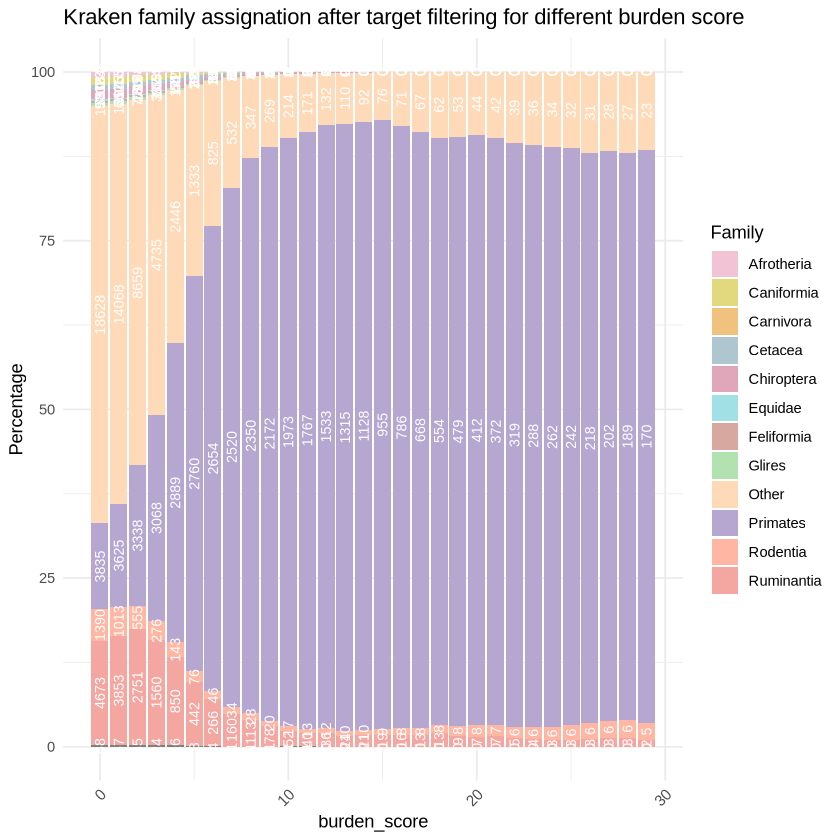

In [7]:
kraken_cumulatif <- kraken_target %>%
  rename(read_id = V1,
         level_1 = V2,
         level_2 = V3) %>%
  #filter(level_1 != "Other") %>%
  full_join(burden_to_read, by = "read_id") %>%  
  full_join(burden, by = c("chrom", "pos")) %>%
  filter(b_3 != ".") %>%
  filter(!is.na(read_id)) %>%
  filter(!is.na(level_1)) %>%
  mutate(n_3 = as.factor(n_3)) %>%
  filter(n_3 == 3) %>%
  mutate(b_3 = as.numeric(as.character(b_3))) %>%
  select(read_id, level_1, n_3, b_3) %>%
  group_by(b_3, n_3) %>%
  mutate(global_count = n()) %>%
  ungroup() %>%
  distinct(b_3, n_3, global_count) %>%
  arrange(b_3) %>%
  mutate(cumulative_global_count = rev(cumsum(rev(global_count)))) %>%
  select(b_3, n_3, cumulative_global_count, global_count)


kraken_read_count <-  kraken_target %>%
  rename(read_id = V1,
         level_1 = V2,
         level_2 = V3) %>%
  #filter(level_1 != "Other") %>%
  full_join(burden_to_read, by = "read_id") %>%  
  full_join(burden, by = c("chrom", "pos")) %>%
  filter(b_3 != ".") %>%
  filter(!is.na(read_id)) %>%
  filter(!is.na(level_1)) %>%
  mutate(n_3 = as.factor(n_3)) %>%
  filter(n_3==3) %>%
  mutate(b_3 = as.numeric(as.character(b_3))) %>%
  select(read_id, level_1, n_3, b_3) %>%
  group_by(b_3, n_3, level_1) %>%
  mutate(read_count = n()) %>%
  ungroup() %>%
  select(-read_id)%>%
  distinct()


new_kraken_output <- expand.grid(
  b_3 = unique(kraken_read_count$b_3),  
  level_1 = unique(kraken_read_count$level_1)  
)

final_output <- new_kraken_output %>%
  left_join(kraken_read_count %>%
              select(b_3, level_1, read_count), by = c("b_3", "level_1")) %>%
  mutate(read_count = ifelse(is.na(read_count), 0, read_count)) %>%
  arrange(b_3) %>%
  group_by(level_1) %>%
  mutate(cumulative_count = rev(cumsum(rev(read_count))))%>%
  ungroup() %>%
  full_join(kraken_cumulatif, by = c("b_3"))%>%
  group_by(b_3, n_3, level_1) %>%
  mutate(percentage = (cumulative_count / sum(cumulative_global_count)) * 100) %>%
  filter(b_3 < 30) %>%
  ungroup()
  
plot_kraken_mapped_bam <- ggplot(final_output, aes(x = b_3, y = percentage, fill = level_1)) +
  geom_bar(stat = "identity", position = "stack") +  # Stack bars for each step
  scale_fill_manual(values = family_colors) +  # Apply the custom colors
  theme_minimal() +  # Use a minimal theme
  labs(
    title = "Kraken family assignation after target filtering for different burden score",
    x = "burden_score",
    y = "Percentage",
    fill = "Family"
  ) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +  # Rotate x-axis labels for readability
  geom_text(aes(label = cumulative_count),  # Add the number of reads as labels
            position = position_stack(vjust = 0.5),  # Place the text in the center of each segment
            color = "white",  # Text color
            size = 3,         # Adjust text size
            angle = 90) 
plot_kraken_mapped_bam



Family level

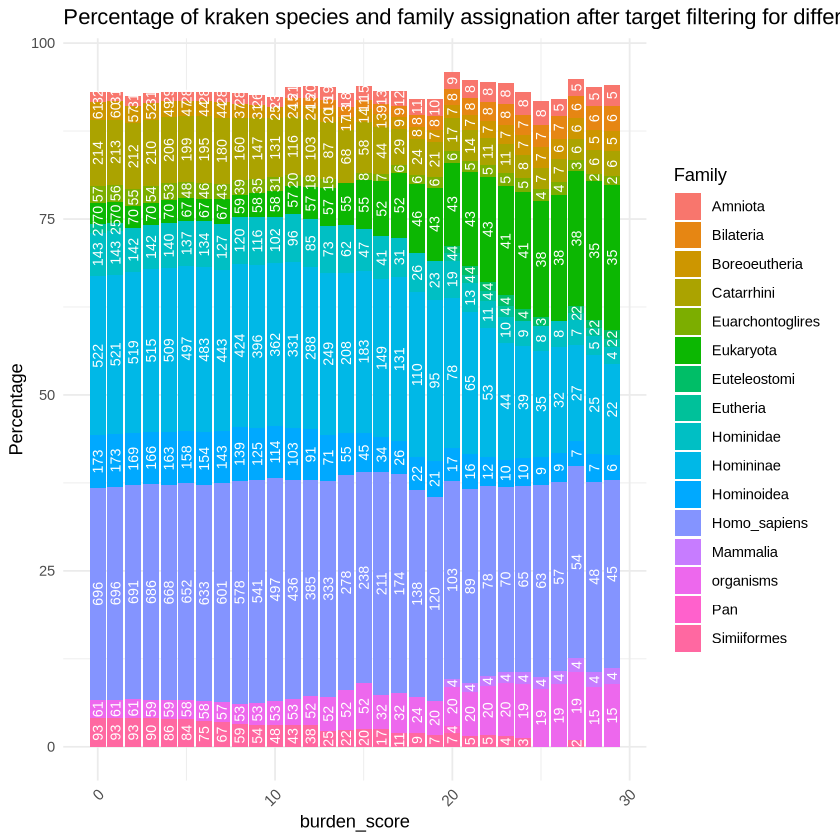

In [14]:
kraken_cumulatif_fam_spe <- kraken_target %>%
  rename(read_id = V1,
         level_1 = V2,
         level_2 = V3) %>%
  #filter(grepl("_", level_2)) %>%
  full_join(burden_to_read, by = "read_id") %>%  
  full_join(burden, by = c("chrom", "pos")) %>%
  filter(b_3 != ".") %>%
  filter(!is.na(read_id)) %>%
  filter(!is.na(level_2)) %>%
  mutate(n_3 = as.factor(n_3)) %>%
  filter(n_3 == 3) %>%
  mutate(b_3 = as.numeric(as.character(b_3))) %>%
  select(read_id, level_2, n_3, b_3) %>%
  group_by(b_3, n_3) %>%
  mutate(global_count = n()) %>%
  ungroup() %>%
  distinct(b_3, n_3, global_count) %>%
  arrange(b_3) %>%
  mutate(cumulative_global_count = rev(cumsum(rev(global_count)))) %>%
  select(b_3, n_3, cumulative_global_count, global_count)



kraken_read_count_fam_spe <-  kraken_target %>%
  rename(read_id = V1,
         level_1 = V2,
         level_2 = V3) %>%
  #filter(grepl("_", level_2)) %>%
  full_join(burden_to_read, by = "read_id") %>%  
  full_join(burden, by = c("chrom", "pos")) %>%
  filter(b_3 != ".") %>%
  filter(!is.na(read_id)) %>%
  filter(!is.na(level_2)) %>%
  mutate(n_3 = as.factor(n_3)) %>%
  filter(n_3==3) %>%
  mutate(b_3 = as.numeric(as.character(b_3))) %>%
  select(read_id, level_2, n_3, b_3) %>%
  group_by(b_3, n_3, level_2) %>%
  mutate(read_count = n()) %>%
  ungroup() %>%
  select(-read_id)%>%
  distinct()


new_kraken_output <- expand.grid(
  b_3 = unique(kraken_read_count_fam_spe$b_3),  
  level_2 = unique(kraken_read_count_fam_spe$level_2)  
)

kraken_fam_spe <- new_kraken_output %>%
  left_join(kraken_read_count_fam_spe %>%
              select(b_3, level_2, read_count), by = c("b_3", "level_2")) %>%
  mutate(read_count = ifelse(is.na(read_count), 0, read_count)) %>%
  arrange(b_3) %>%
  group_by(level_2) %>%
  mutate(cumulative_count = rev(cumsum(rev(read_count))))%>%
  ungroup() %>%
  full_join(kraken_cumulatif_fam_spe, by = c("b_3"))%>%
  group_by(b_3, n_3, level_2) %>%
  mutate(percentage = (cumulative_count / sum(cumulative_global_count)) * 100) %>%
  filter(b_3 < 30) %>%
  ungroup() %>%
 filter(percentage > "1") 
 

plot_kraken_fam_spe <- ggplot(kraken_fam_spe, aes(x = b_3, y = percentage, fill = level_2)) +
  geom_bar(stat = "identity", position = "stack") +  # Stack bars for each step
  #scale_fill_manual(values = family_colors) +  # Apply the custom colors
  theme_minimal() +  # Use a minimal theme
  labs(
    title = "Percentage of kraken species and family assignation after target filtering for different burden score",
    x = "burden_score",
    y = "Percentage",
    fill = "Family"
  ) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  ) + 
  geom_text(aes(label = cumulative_count),  # Add the number of reads as labels
            position = position_stack(vjust = 0.5),  # Place the text in the center of each segment
            color = "white",  # Text color
            size = 3,         # Adjust text size
            angle = 90)       # Rotate text to be vertical

plot_kraken_fam_spe
  

Species level

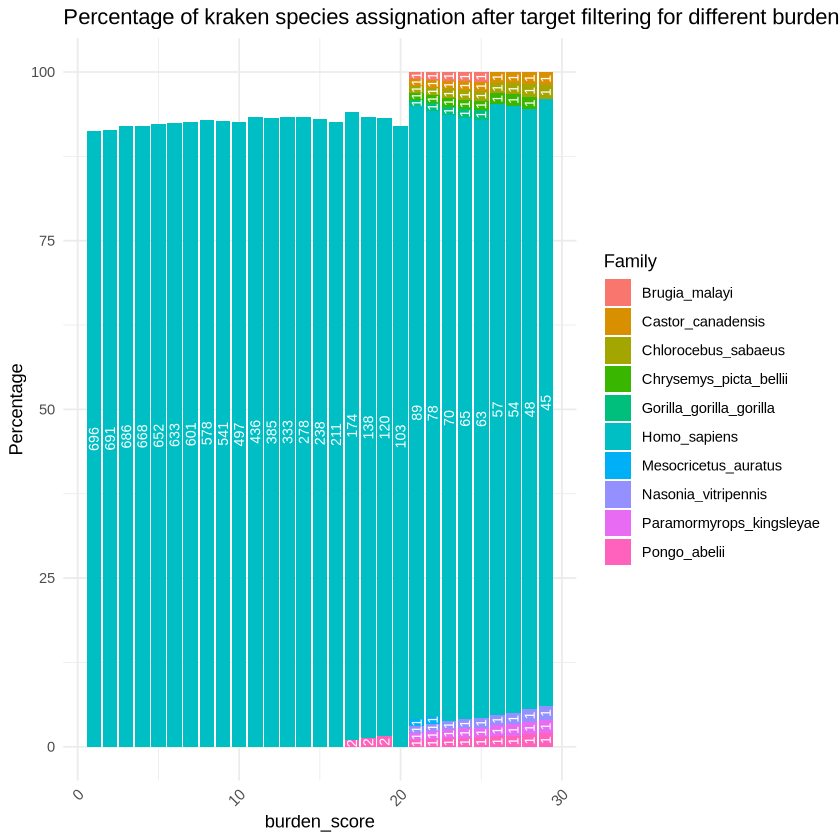

In [15]:
kraken_cumulatif_SPECIES <- kraken_target %>%
  rename(read_id = V1,
         level_1 = V2,
         level_2 = V3) %>%
  filter(grepl("_", level_2)) %>%
  full_join(burden_to_read, by = "read_id") %>%  
  full_join(burden, by = c("chrom", "pos")) %>%
  filter(b_3 != ".") %>%
  filter(!is.na(read_id)) %>%
  filter(!is.na(level_2)) %>%
  mutate(n_3 = as.factor(n_3)) %>%
  filter(n_3 == 3) %>%
  mutate(b_3 = as.numeric(as.character(b_3))) %>%
  select(read_id, level_2, n_3, b_3) %>%
  group_by(b_3, n_3) %>%
  mutate(global_count = n()) %>%
  ungroup() %>%
  distinct(b_3, n_3, global_count) %>%
  arrange(b_3) %>%
  mutate(cumulative_global_count = rev(cumsum(rev(global_count)))) %>%
  select(b_3, n_3, cumulative_global_count, global_count)



kraken_read_count_SPECIES <-  kraken_target %>%
  rename(read_id = V1,
         level_1 = V2,
         level_2 = V3) %>%
  filter(grepl("_", level_2)) %>%
  full_join(burden_to_read, by = "read_id") %>%  
  full_join(burden, by = c("chrom", "pos")) %>%
  filter(b_3 != ".") %>%
  filter(!is.na(read_id)) %>%
  filter(!is.na(level_2)) %>%
  mutate(n_3 = as.factor(n_3)) %>%
  filter(n_3==3) %>%
  mutate(b_3 = as.numeric(as.character(b_3))) %>%
  select(read_id, level_2, n_3, b_3) %>%
  group_by(b_3, n_3, level_2) %>%
  mutate(read_count = n()) %>%
  ungroup() %>%
  select(-read_id)%>%
  distinct()


new_kraken_output <- expand.grid(
  b_3 = unique(kraken_read_count_SPECIES$b_3),  
  level_2 = unique(kraken_read_count_SPECIES$level_2)  
)

kraken_SPECIES <- new_kraken_output %>%
  left_join(kraken_read_count_SPECIES %>%
              select(b_3, level_2, read_count), by = c("b_3", "level_2")) %>%
  mutate(read_count = ifelse(is.na(read_count), 0, read_count)) %>%
  arrange(b_3) %>%
  group_by(level_2) %>%
  mutate(cumulative_count = rev(cumsum(rev(read_count))))%>%
  ungroup() %>%
  full_join(kraken_cumulatif_SPECIES, by = c("b_3"))%>%
  group_by(b_3, n_3, level_2) %>%
  mutate(percentage = (cumulative_count / sum(cumulative_global_count)) * 100) %>%
  filter(b_3 < 30) %>%
  ungroup() %>%
 filter(percentage > "1") 
 

plot_kraken_SPECIES <- ggplot(kraken_SPECIES, aes(x = b_3, y = percentage, fill = level_2)) +
  geom_bar(stat = "identity", position = "stack") +  # Stack bars for each step
  #scale_fill_manual(values = family_colors) +  # Apply the custom colors
  theme_minimal() +  # Use a minimal theme
  labs(
    title = "Percentage of kraken species assignation after target filtering for different burden score",
    x = "burden_score",
    y = "Percentage",
    fill = "Family"
  ) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  ) + 
  geom_text(aes(label = cumulative_count),  # Add the number of reads as labels
            position = position_stack(vjust = 0.5),  # Place the text in the center of each segment
            color = "white",  # Text color
            size = 3,         # Adjust text size
            angle = 90)       # Rotate text to be vertical

plot_kraken_SPECIES
  

In [17]:
library(knitr)
library(data.table)
library(tidyverse)

read_to_burden <- "/mnt/expressions/Aurore/sediment_pipeline_v0/output_v0/mappedbams/Lib.L.5232/TW1/rmdupL35MQ25/target/0_filter/Lib.L.5232.read_summary.txt.gz"

kraken_byread <- "/mnt/expressions/Aurore/sediment_pipeline_v0/output_v0/mappedbams/Lib.L.5232/TW1/rmdupL35MQ25/target/0_filter/Lib.L.5232.byread"

burden_path <- "/mnt/expressions/benjamin_vernot/soil_capture_2017/site_categories_for_capture/twist_1240k_2023_09/twist.1240k.burden.txt"

kraken_target <- fread(kraken_byread, header =FALSE)

burden_to_read <- fread(read_to_burden) %>%
  select(read_id,chrom,pos)

burden <- fread(burden_path) %>%
  select(chrom, pos0, pos, n_3, b_3)


family_colors <- c(
  "Other" = "#FFDAB9",           # Pastel Peach
  "Cetacea" = "#AEC6CF",         # Pastel Blue
  "Rodentia" = "#FFB6A2",        # Pastel Orange
  "Glires" = "#B2E2B0",          # Pastel Green
  "Ruminantia" = "#F4A6A1",      # Pastel Red
  "Primates" = "#B6A7D1",        # Pastel Purple
  "Feliformia" = "#D7A8A0",      # Pastel Brown
  "Afrotheria" = "#F1C3D5",      # Pastel Pink
  "Equidae" = "#A1E1E6",         # Pastel Cyan
  "Chiroptera" = "#E0A6B9",      # Pastel Crimson
  "Caniformia" = "#E2D97F",      # Pastel Olive Green
  "Carnivora" = "#F1C27D"        # Pastel Yellow-orange
)


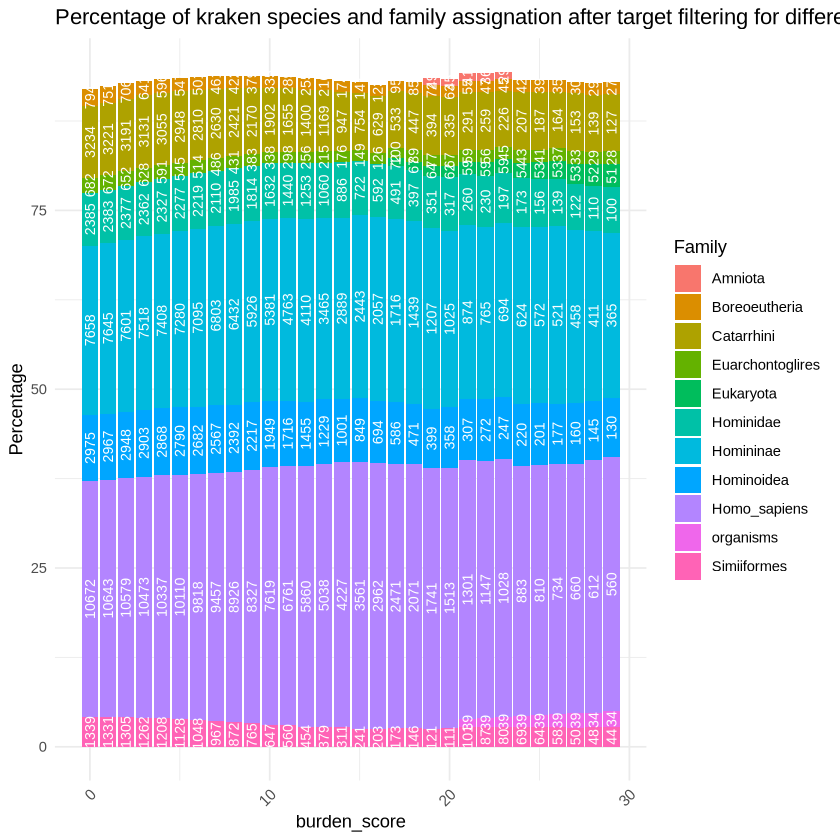

In [18]:
kraken_cumulatif_fam_spe <- kraken_target %>%
  rename(read_id = V1,
         level_1 = V2,
         level_2 = V3) %>%
  #filter(grepl("_", level_2)) %>%
  full_join(burden_to_read, by = "read_id") %>%  
  full_join(burden, by = c("chrom", "pos")) %>%
  filter(b_3 != ".") %>%
  filter(!is.na(read_id)) %>%
  filter(!is.na(level_2)) %>%
  mutate(n_3 = as.factor(n_3)) %>%
  filter(n_3 == 3) %>%
  mutate(b_3 = as.numeric(as.character(b_3))) %>%
  select(read_id, level_2, n_3, b_3) %>%
  group_by(b_3, n_3) %>%
  mutate(global_count = n()) %>%
  ungroup() %>%
  distinct(b_3, n_3, global_count) %>%
  arrange(b_3) %>%
  mutate(cumulative_global_count = rev(cumsum(rev(global_count)))) %>%
  select(b_3, n_3, cumulative_global_count, global_count)



kraken_read_count_fam_spe <-  kraken_target %>%
  rename(read_id = V1,
         level_1 = V2,
         level_2 = V3) %>%
  #filter(grepl("_", level_2)) %>%
  full_join(burden_to_read, by = "read_id") %>%  
  full_join(burden, by = c("chrom", "pos")) %>%
  filter(b_3 != ".") %>%
  filter(!is.na(read_id)) %>%
  filter(!is.na(level_2)) %>%
  mutate(n_3 = as.factor(n_3)) %>%
  filter(n_3==3) %>%
  mutate(b_3 = as.numeric(as.character(b_3))) %>%
  select(read_id, level_2, n_3, b_3) %>%
  group_by(b_3, n_3, level_2) %>%
  mutate(read_count = n()) %>%
  ungroup() %>%
  select(-read_id)%>%
  distinct()


new_kraken_output <- expand.grid(
  b_3 = unique(kraken_read_count_fam_spe$b_3),  
  level_2 = unique(kraken_read_count_fam_spe$level_2)  
)

kraken_fam_spe <- new_kraken_output %>%
  left_join(kraken_read_count_fam_spe %>%
              select(b_3, level_2, read_count), by = c("b_3", "level_2")) %>%
  mutate(read_count = ifelse(is.na(read_count), 0, read_count)) %>%
  arrange(b_3) %>%
  group_by(level_2) %>%
  mutate(cumulative_count = rev(cumsum(rev(read_count))))%>%
  ungroup() %>%
  full_join(kraken_cumulatif_fam_spe, by = c("b_3"))%>%
  group_by(b_3, n_3, level_2) %>%
  mutate(percentage = (cumulative_count / sum(cumulative_global_count)) * 100) %>%
  filter(b_3 < 30) %>%
  ungroup() %>%
 filter(percentage > "1") 
 

plot_kraken_fam_spe <- ggplot(kraken_fam_spe, aes(x = b_3, y = percentage, fill = level_2)) +
  geom_bar(stat = "identity", position = "stack") +  # Stack bars for each step
  #scale_fill_manual(values = family_colors) +  # Apply the custom colors
  theme_minimal() +  # Use a minimal theme
  labs(
    title = "Percentage of kraken species and family assignation after target filtering for different burden score",
    x = "burden_score",
    y = "Percentage",
    fill = "Family"
  ) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  ) + 
  geom_text(aes(label = cumulative_count),  # Add the number of reads as labels
            position = position_stack(vjust = 0.5),  # Place the text in the center of each segment
            color = "white",  # Text color
            size = 3,         # Adjust text size
            angle = 90)       # Rotate text to be vertical

plot_kraken_fam_spe
  

CODE TO IMPLEMENT IN PIPELINE FOR SPECIES/FAMILY

In [3]:
library(knitr)
library(data.table)
library(tidyverse)

read_to_burden <- "/mnt/expressions/Aurore/sediment_pipeline_v0/output_v0/mappedbams/A0101/1240k/rmdupL35MQ25/target/0_filter/A0101.read_summary.txt.gz"

kraken_byread <- "/mnt/expressions/Aurore/sediment_pipeline_v0/output_v0/mappedbams/A0101/1240k/rmdupL35MQ25/target/0_filter/A0101.byread"

burden_path <- "/mnt/expressions/Aurore/sediment_pipeline_test/1240k/1240k.burden.txt"
kraken_target <- fread(kraken_byread, header =FALSE)

burden_to_read <- fread(read_to_burden) %>%
  select(read_id,chrom,pos)

burden <- fread(burden_path) %>%
  select(chrom, pos0, pos, n_3, b_3)

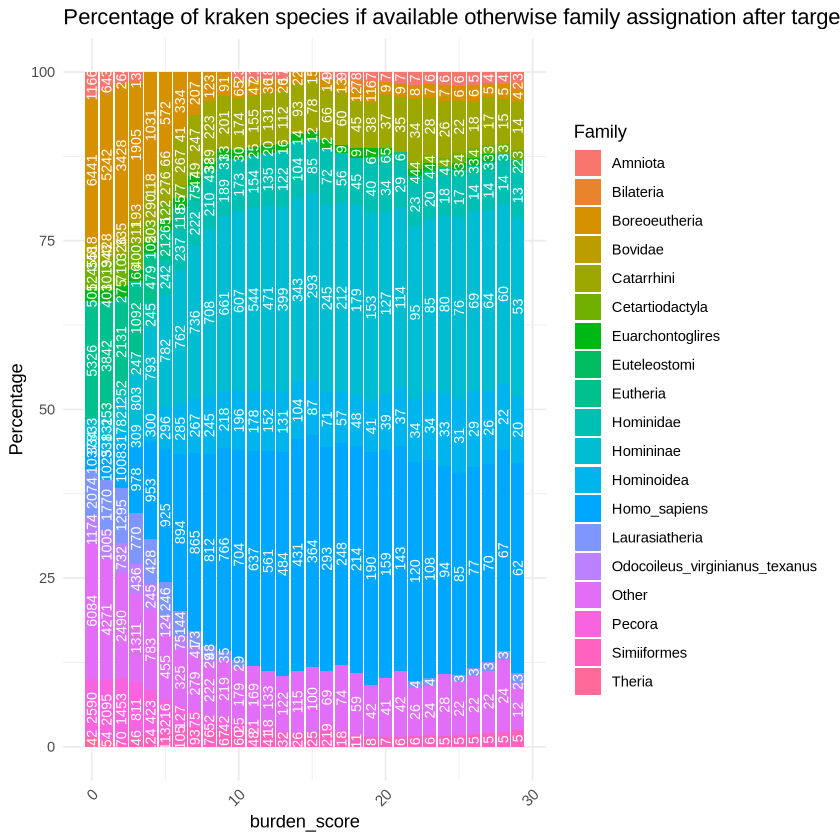

In [4]:
kraken_cumulatif_fam_spe <- kraken_target %>%
  rename(read_id = V1,
         level_1 = V2,
         level_2 = V3) %>%
  #filter(grepl("_", level_2)) %>%
  full_join(burden_to_read, by = "read_id") %>%  
  full_join(burden, by = c("chrom", "pos")) %>%
  filter(b_3 != ".") %>%
  filter(!is.na(read_id)) %>%
  filter(!is.na(level_2)) %>%
  mutate(n_3 = as.factor(n_3)) %>%
  filter(n_3 == 3) %>%
  mutate(b_3 = as.numeric(as.character(b_3))) %>%
  select(read_id, level_2, n_3, b_3) %>%
  group_by(b_3, n_3) %>%
  mutate(global_count = n()) %>%
  ungroup() %>%
  distinct(b_3, n_3, global_count) %>%
  arrange(b_3) %>%
  mutate(cumulative_global_count = rev(cumsum(rev(global_count)))) %>%
  select(b_3, n_3, cumulative_global_count, global_count)



kraken_read_count_fam_spe <-  kraken_target %>%
  rename(read_id = V1,
         level_1 = V2,
         level_2 = V3) %>%
  #filter(grepl("_", level_2)) %>%
  full_join(burden_to_read, by = "read_id") %>%  
  full_join(burden, by = c("chrom", "pos")) %>%
  filter(b_3 != ".") %>%
  filter(!is.na(read_id)) %>%
  filter(!is.na(level_2)) %>%
  mutate(n_3 = as.factor(n_3)) %>%
  filter(n_3==3) %>%
  mutate(b_3 = as.numeric(as.character(b_3))) %>%
  select(read_id, level_2, n_3, b_3) %>%
  group_by(b_3, n_3, level_2) %>%
  mutate(read_count = n()) %>%
  ungroup() %>%
  select(-read_id)%>%
  distinct()


new_kraken_output <- expand.grid(
  b_3 = unique(kraken_read_count_fam_spe$b_3),  
  level_2 = unique(kraken_read_count_fam_spe$level_2)  
)

#regrouping every family and species <1% in "Other" and removing number of reads for this cattegory
kraken_fam_spe <- new_kraken_output %>%
  left_join(kraken_read_count_fam_spe %>%
              select(b_3, level_2, read_count), by = c("b_3", "level_2")) %>%
  mutate(read_count = ifelse(is.na(read_count), 0, read_count)) %>%
  arrange(b_3) %>%
  group_by(level_2) %>%
  mutate(cumulative_count = rev(cumsum(rev(read_count)))) %>%
  ungroup() %>%
  full_join(kraken_cumulatif_fam_spe, by = c("b_3")) %>%
  group_by(b_3, n_3, level_2) %>%
  mutate(percentage = (cumulative_count / sum(cumulative_global_count)) * 100) %>%
  filter(b_3 < 30) %>%
  ungroup() %>%
  mutate(level_2 = ifelse(percentage < 1, "Other", level_2)) %>% 
  group_by(b_3,level_2) %>%
  mutate(cumulative_count = ifelse(level_2 == "Other", sum(cumulative_count), cumulative_count))%>% 
  mutate(percentage = ifelse(level_2 == "Other", sum(percentage), percentage))%>%
  ungroup() %>%
  distinct(b_3,level_2, cumulative_count, percentage)

#distinct(level_2, b_3, cumulative_count, .keep_all = TRUE) 

plot_kraken_fam_spe <- ggplot(kraken_fam_spe, aes(x = b_3, y = percentage, fill = level_2)) +
  geom_bar(stat = "identity", position = "stack") +  # Stack bars for each step
  #scale_fill_manual(values = family_colors) +  # Apply the custom colors
  theme_minimal() +  # Use a minimal theme
  labs(
    title = "Percentage of kraken species if available otherwise family assignation after target filtering by burden score (and n=3)",
    x = "burden_score",
    y = "Percentage",
    fill = "Family"
  ) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  ) +
  geom_text(aes(label = cumulative_count),  # Add the number of reads as labels
            position = position_stack(vjust = 0.5),  # Place the text in the center of each segment
            color = "white",  # Text color
            size = 3,         # Adjust text size
            angle = 90,)   # Rotate text to be vertical

plot_kraken_fam_spe

In [6]:
library(knitr)
library(data.table)
library(tidyverse)

read_to_burden <- "/mnt/expressions/Aurore/sediment_pipeline_v0/output_v0/mappedbams/A0101/1240k/rmdupL35MQ25/target/0_filter/deam/A0101.read_summary.txt.gz"

kraken_byread <- "/mnt/expressions/Aurore/sediment_pipeline_v0/output_v0/mappedbams/A0101/1240k/rmdupL35MQ25/target/0_filter/deam/A0101.byread"

burden_path <- "/mnt/expressions/Aurore/sediment_pipeline_test/1240k/1240k.burden.txt"
kraken_target <- fread(kraken_byread, header =FALSE)

burden_to_read <- fread(read_to_burden) %>%
  select(read_id,chrom,pos)

burden <- fread(burden_path) %>%
  select(chrom, pos0, pos, n_3, b_3)

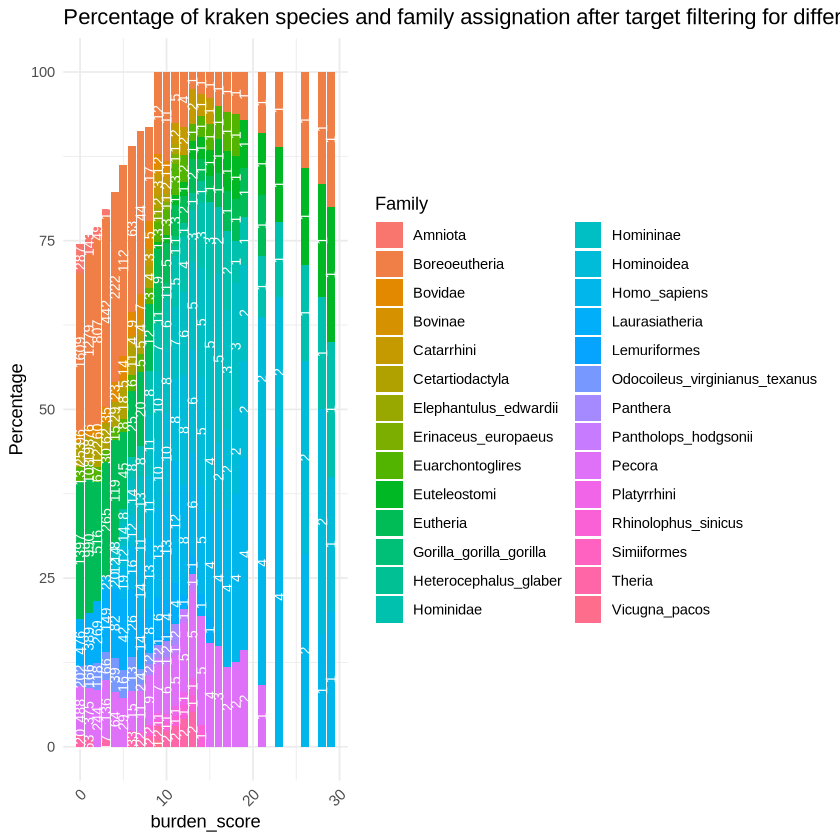

In [7]:
kraken_cumulatif_fam_spe <- kraken_target %>%
  rename(read_id = V1,
         level_1 = V2,
         level_2 = V3) %>%
  #filter(grepl("_", level_2)) %>%
  full_join(burden_to_read, by = "read_id") %>%  
  full_join(burden, by = c("chrom", "pos")) %>%
  filter(b_3 != ".") %>%
  filter(!is.na(read_id)) %>%
  filter(!is.na(level_2)) %>%
  mutate(n_3 = as.factor(n_3)) %>%
  filter(n_3 == 3) %>%
  mutate(b_3 = as.numeric(as.character(b_3))) %>%
  select(read_id, level_2, n_3, b_3) %>%
  group_by(b_3, n_3) %>%
  mutate(global_count = n()) %>%
  ungroup() %>%
  distinct(b_3, n_3, global_count) %>%
  arrange(b_3) %>%
  mutate(cumulative_global_count = rev(cumsum(rev(global_count)))) %>%
  select(b_3, n_3, cumulative_global_count, global_count)



kraken_read_count_fam_spe <-  kraken_target %>%
  rename(read_id = V1,
         level_1 = V2,
         level_2 = V3) %>%
  #filter(grepl("_", level_2)) %>%
  full_join(burden_to_read, by = "read_id") %>%  
  full_join(burden, by = c("chrom", "pos")) %>%
  filter(b_3 != ".") %>%
  filter(!is.na(read_id)) %>%
  filter(!is.na(level_2)) %>%
  mutate(n_3 = as.factor(n_3)) %>%
  filter(n_3==3) %>%
  mutate(b_3 = as.numeric(as.character(b_3))) %>%
  select(read_id, level_2, n_3, b_3) %>%
  group_by(b_3, n_3, level_2) %>%
  mutate(read_count = n()) %>%
  ungroup() %>%
  select(-read_id)%>%
  distinct()


new_kraken_output <- expand.grid(
  b_3 = unique(kraken_read_count_fam_spe$b_3),  
  level_2 = unique(kraken_read_count_fam_spe$level_2)  
)

kraken_fam_spe <- new_kraken_output %>%
  left_join(kraken_read_count_fam_spe %>%
              select(b_3, level_2, read_count), by = c("b_3", "level_2")) %>%
  mutate(read_count = ifelse(is.na(read_count), 0, read_count)) %>%
  arrange(b_3) %>%
  group_by(level_2) %>%
  mutate(cumulative_count = rev(cumsum(rev(read_count))))%>%
  ungroup() %>%
  full_join(kraken_cumulatif_fam_spe, by = c("b_3"))%>%
  group_by(b_3, n_3, level_2) %>%
  mutate(percentage = (cumulative_count / sum(cumulative_global_count)) * 100) %>%
  filter(b_3 < 30) %>%
  ungroup() %>%
 filter(percentage > "1") 
 

plot_kraken_fam_spe <- ggplot(kraken_fam_spe, aes(x = b_3, y = percentage, fill = level_2)) +
  geom_bar(stat = "identity", position = "stack") +  # Stack bars for each step
  #scale_fill_manual(values = family_colors) +  # Apply the custom colors
  theme_minimal() +  # Use a minimal theme
  labs(
    title = "Percentage of kraken species and family assignation after target filtering for different burden score",
    x = "burden_score",
    y = "Percentage",
    fill = "Family"
  ) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  ) + 
  geom_text(aes(label = cumulative_count),  # Add the number of reads as labels
            position = position_stack(vjust = 0.5),  # Place the text in the center of each segment
            color = "white",  # Text color
            size = 3,         # Adjust text size
            angle = 90)       # Rotate text to be vertical

plot_kraken_fam_spe
  

In [10]:
library(ggplot2)
library(patchwork)


coverage_path <- "/mnt/expressions/Aurore/sediment_pipeline_v0/output_v0/mappedbams/A0101/1240k/rmdupL35MQ25/target/0_filter/A0101.cov"
burden_path <- "/mnt/expressions/Aurore/sediment_pipeline_test/1240k/1240k.burden.txt"

burden <- fread(burden_path) %>%
  select(chrom, pos0, pos, n_3, b_3)

x_limits <- range(c(cov_plot$data$b_3, burden_SNPs_plot$data$b_3), na.rm = TRUE)

#coverage
burden_number <- burden %>%
  select(pos, n_3, b_3) %>%
  filter(b_3 != ".") %>%
  mutate(b_3 = as.numeric(as.character(b_3))) %>%
  filter(b_3 < 30) %>%
  group_by(n_3, b_3) %>%
  summarize(count = n(), .groups = "drop") %>%  
  distinct(b_3, n_3, .keep_all = TRUE)

coverage <-  fread(coverage_path, header = FALSE) %>%
  select(V1, V2, V4) %>%
  rename(pos = V2,
         coverage = V4) %>%
  filter(coverage > 0) %>%
  left_join(burden, by = "pos")  %>%
  filter(b_3!=".") %>%
  filter(!is.na(b_3)) %>%
  filter(!is.na(coverage)) %>%
  mutate(b_3 = as.numeric(as.character(b_3))) %>%
  select(coverage, n_3,b_3) %>%
  group_by(b_3, n_3) %>%
  summarise(total_coverage = sum(coverage), .groups = 'drop') %>%
  left_join(burden_number, by = c("b_3", "n_3")) %>%
  group_by(b_3, n_3) %>%
  mutate(total_coverage = total_coverage/count) %>%
  mutate(n_3 = as.factor(n_3)) %>%
  mutate(b_3 = as.numeric(as.character(b_3))) %>%
  filter(b_3 < 30) 

cov_plot <- ggplot(coverage, aes(x = b_3, y = total_coverage, color = as.factor(n_3), group = n_3)) + 
  geom_line(linetype = "dashed") +  # Dashed lines
  geom_point() +                    # Points at each data point
  labs(x = "B Score (b_3)", 
       y = "Coverage", 
       color = "N Score") + 
  ylim(0,1)+
  theme_minimal()+
  theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        legend.text = element_blank()) +
  scale_y_continuous(position = "left") +
  theme(
    axis.title.y.right = element_text(angle = 90),
    axis.text.y.right = element_text(),
   # axis.title.x = element_blank() 
  ) +
  scale_x_continuous(limits = x_limits) 



#number of SNPs for each b and n score
burden_SNPs <- burden %>%
  select(pos, n_3, b_3) %>%
  filter(b_3 != ".") %>%
  mutate(b_3 = as.numeric(as.character(b_3))) %>%
  filter(b_3 < 30) %>%
  group_by(n_3, b_3) %>%
  summarize(count = n(), .groups = "drop") %>%  # Use summarize instead of mutate for count
  distinct(b_3, n_3, .keep_all = TRUE)


burden_SNPs_plot <- ggplot(burden_SNPs, aes(x = b_3, y = count, fill = as.factor(n_3))) +
 # geom_bar(stat = "identity", alpha = 0.5) +
  labs(x = "", 
       y = "Total Number of Positions", 
       fill = "N Score") +  # Correctly labels the fill aesthetic
  theme_minimal() +
  theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank()) +
  scale_y_continuous(position = "right") +
  theme(
    axis.title.y.right = element_text(angle = 90),
    axis.text.y.right = element_text()
  )
  
burden_SNPs_plot




ERROR: Error in eval(expr, envir, enclos): object 'cov_plot' not found


Warning message in left_join(., burden, by = "pos"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1259 of `x` matches multiple rows in `y`.
ℹ Row 101229 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


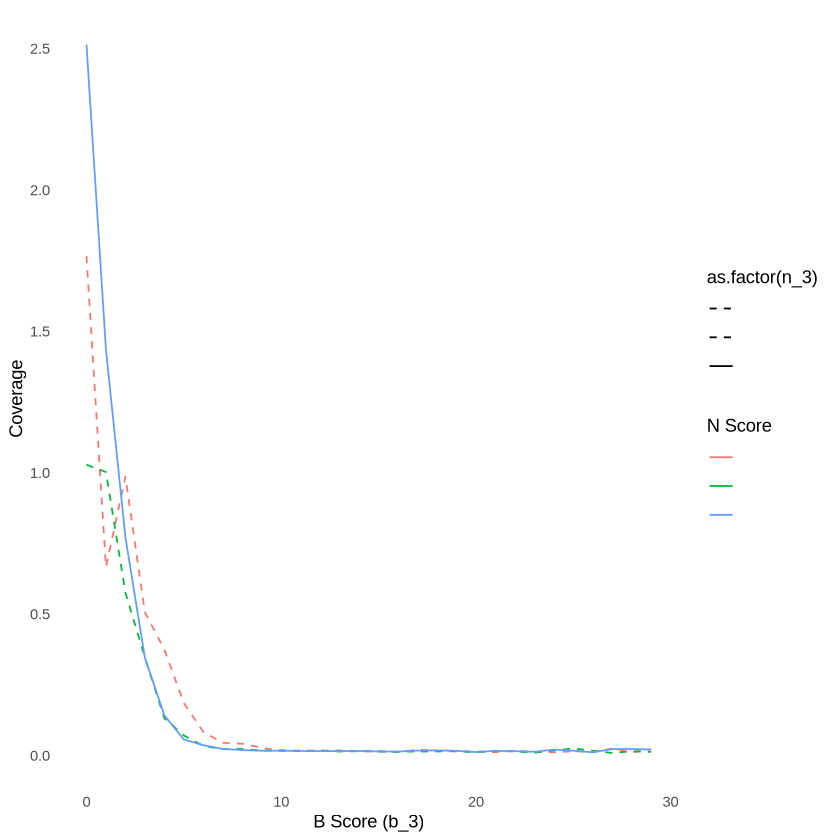

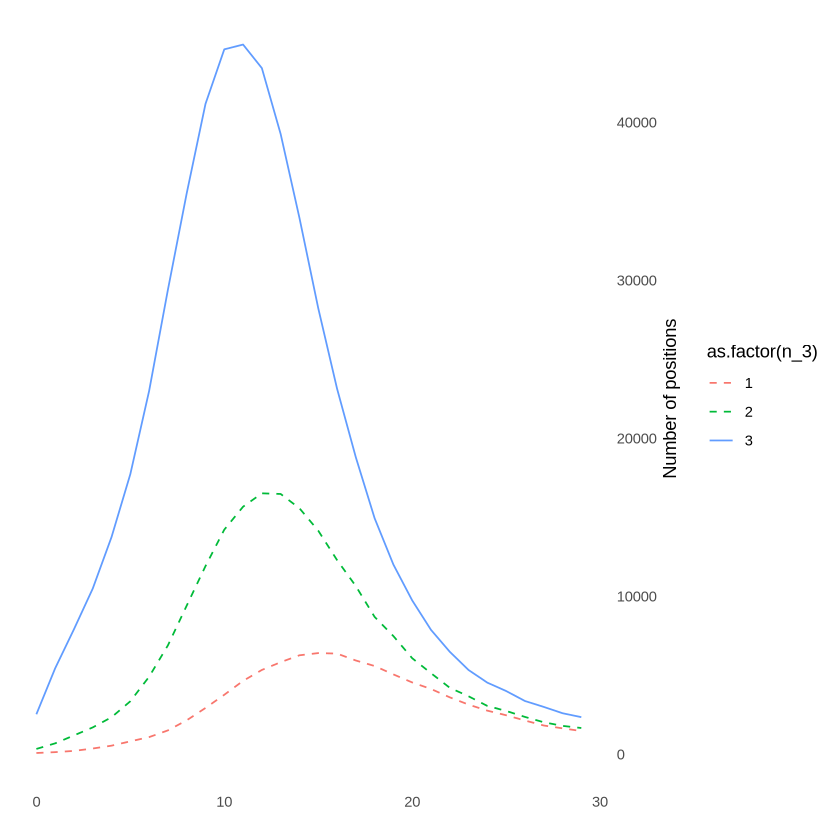

In [50]:
library(ggplot2)
library(patchwork)
library(tidyverse)
library(knitr)
library(data.table)

coverage_path <- "/mnt/expressions/Aurore/sediment_pipeline_v0/output_v0/mappedbams/A0101/1240k/rmdupL35MQ25/target/0_filter/A0101.cov"
burden_path <- "/mnt/expressions/Aurore/sediment_pipeline_test/1240k/1240k.burden.txt"

burden <- fread(burden_path) %>%
  select(chrom, pos0, pos, n_3, b_3)

#coverage
burden_number <- burden %>%
  select(pos, n_3, b_3) %>%
  filter(b_3 != ".") %>%
  mutate(b_3 = as.numeric(as.character(b_3))) %>%
  filter(b_3 < 30) %>%
  group_by(n_3, b_3) %>%
  summarize(count = n(), .groups = "drop") %>%
  distinct(b_3, n_3, .keep_all = TRUE)


coverage <-  fread(coverage_path, header = FALSE) %>%
  select(V1, V2, V4) %>%
  rename(pos = V2,
         coverage = V4) %>%
  filter(coverage > 0) %>%
  left_join(burden, by = "pos")  %>%
  filter(b_3!=".") %>%
  filter(!is.na(b_3)) %>%
  filter(!is.na(coverage)) %>%
  mutate(b_3 = as.numeric(as.character(b_3))) %>%
  select(coverage, n_3,b_3) %>%
  group_by(b_3, n_3) %>%
  summarise(total_coverage = sum(coverage), .groups = 'drop') %>%
  left_join(burden_number, by = c("b_3", "n_3")) %>%
  group_by(b_3, n_3) %>%
  mutate(total_coverage = total_coverage/count) %>%
  mutate(n_3 = as.factor(n_3)) %>%
  mutate(b_3 = as.numeric(as.character(b_3))) %>%
  filter(b_3 < 30) 

cov_plot <- ggplot(coverage, aes(x = b_3, y = total_coverage, color = as.factor(n_3), linetype = as.factor(n_3)))+  
 # geom_point() +   
  geom_line() +                
  labs(x = "B Score (b_3)", 
       y = "Coverage", 
       color = "N Score") + 
  ylim(0,1)+
  theme_minimal()+
  theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        legend.text = element_blank()) +
  scale_y_continuous(position = "left") +
  theme(
    axis.title.y.right = element_text(angle = 90),
    axis.text.y.right = element_text(),
   # axis.title.x = element_blank() 
  ) +
  scale_linetype_manual(values = c("1" = "dashed", "2" = "dashed", "3" = "solid")) +
 scale_y_continuous(name = "Coverage")  

cov_plot

#number of SNPs for each b and n score
burden_SNPs <- burden %>%
  select(pos, n_3, b_3) %>%
  filter(b_3 != ".") %>%
  mutate(b_3 = as.numeric(as.character(b_3))) %>%
  filter(b_3 < 30) %>%
  group_by(n_3, b_3) %>%
  summarize(count = n(), .groups = "drop") %>%  # Use summarize instead of mutate for count
  distinct(b_3, n_3, .keep_all = TRUE)  %>%
  mutate(n_3 = as.factor(n_3))


burden_SNPs_plot <- ggplot(burden_SNPs, aes(x = b_3, y = count, color = as.factor(n_3), linetype = as.factor(n_3))) +
  geom_line() +  # geom_line automatically uses the linetype aesthetic
  labs(x = "", 
       y = "Total Number of Positions", 
       fill = "N Score") + 
  theme_minimal() +
  theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank()) +
  scale_y_continuous(position = "right") +
  theme(
    axis.title.y.right = element_text(angle = 90),
    axis.text.y.right = element_text()
  ) +
  scale_linetype_manual(values = c("1" = "dashed", "2" = "dashed", "3" = "solid"))  +
  scale_y_continuous(name = "Number of positions", position = "right")  


  
burden_SNPs_plot





TO IMPLEMENT

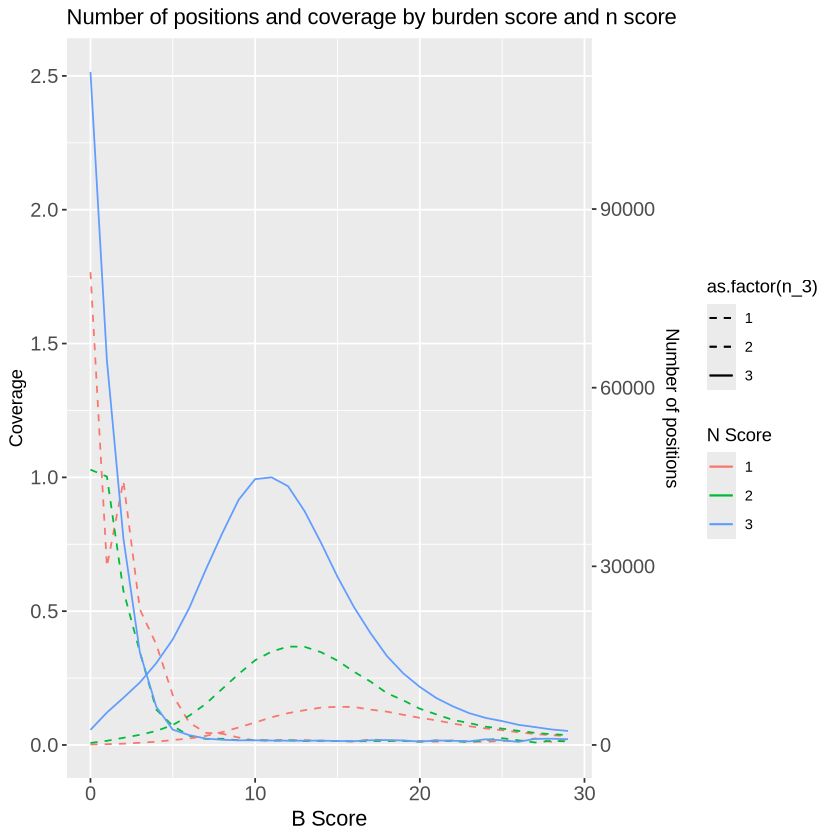

In [70]:
library(ggplot2)
library(dplyr)

#number of position max (will change from one capture set to another)
max_burden <- max(burden_SNPs$count, na.rm = TRUE)  

data <- coverage %>%
  left_join(burden_SNPs, by = c("b_3", "n_3", "count"))

coeff <- max_burden 

# plot coverage and number of SNPs
ggplot(data) +
  geom_line(aes(x = b_3, y = total_coverage, color = as.factor(n_3), linetype = as.factor(n_3))) +
  geom_line(aes(x = b_3, y = count / coeff, color = as.factor(n_3),linetype = as.factor(n_3)) )+ 
  
  scale_y_continuous(
    name = "Coverage",  
   # limits = c(0, 1),   
    sec.axis = sec_axis(~ . * coeff, name = "Number of positions")  
  ) +
  scale_color_discrete(name = "N Score") +
  labs(x = "B Score") +
  theme(
 #   axis.title.y = element_text(color = "blue", size = 13),  # Left axis title (Coverage)
  #  axis.title.y.right = element_text(color = "red", size = 13),  # Right axis title (burden_SNPs)
    axis.text = element_text(size = 12),  # Axis text size
    axis.title.x = element_text(size = 13)  # X-axis title size
  ) +
  scale_linetype_manual(values = c("1" = "dashed", "2" = "dashed", "3" = "solid"))  +
  
  ggtitle("Number of positions and coverage by burden score and n score") 
